In [272]:
import numpy as np
import matplotlib.pyplot as plt
import spectral as sp

from ipynb.fs.full.SeedMaskExtractor import extract_seed_pixels
from ipynb.fs.full.SeedFinder import healthy_seeds, infected_seeds

In [273]:
def plot_spectra(spectra, title='Spectra', start_wavelength=395, end_wavelength=1005, num_bands=840, start_band=100, end_band=740, is_log=False):
    wavelengths = np.linspace(start_wavelength, end_wavelength, num_bands)[start_band:end_band]
    plt.figure(figsize=(10, 6))
    for i, spectrum in enumerate(spectra):
        plt.plot(wavelengths, spectrum)
    plt.title(title)
    plt.xlabel('Wavelength')
    plt.ylabel('Relative Reflectance / Intensity')
    if is_log:
        plt.log
    plt.show()

In [274]:
healthy_all_seeds_pixels = np.vstack([extract_seed_pixels(np.load(path)) for path in healthy_seeds])
infected_all_seeds_pixels = np.vstack([extract_seed_pixels(np.load(path)) for path in infected_seeds])

total_size = min(healthy_all_seeds_pixels.shape[0], infected_all_seeds_pixels.shape[0])
num_samples = 100
random_all_seeds_pixels = np.random.choice(30000, 100, replace=False)

healthy_sampled_all_seeds = healthy_all_seeds_pixels[random_all_seeds_pixels,:]
infected_sampled_all_seeds = infected_all_seeds_pixels[random_all_seeds_pixels,:]

In [275]:
def apply_msc_and_shift_positive(image, ref_spectrum, is_apply_shift_positive=True):
    corrected_spectra = []

    for spectrum in image:
        corrected = (spectrum - np.mean(spectrum)) / np.std(spectrum)
        corrected = corrected * np.std(ref_spectrum) + np.mean(ref_spectrum)
        corrected_spectra.append(corrected)
    
    corrected_spectra = np.array(corrected_spectra)

    if is_apply_shift_positive:
        min_value = np.min(corrected_spectra)
        if min_value < 0:
            shift_value = np.abs(min_value)
            corrected_spectra += shift_value
    
    return corrected_spectra

In [276]:
def zscore_normalize(image):
    mean_vals = np.mean(image, axis=(0, 1), keepdims=True)  # Mean per band
    std_vals = np.std(image, axis=(0, 1), keepdims=True)  # Standard deviation per band
    normalized = (image - mean_vals) / (std_vals + 1e-8)  # Avoid division by zero
    return normalized

In [277]:
def calculate_total_seeds_mean_per_band(seeds_paths):
    total_mean = 0
    for path in seeds_paths:
        seed_pixels_all = extract_seed_pixels(np.load(path))
        total_mean += np.mean(seed_pixels_all, axis=(0))
    
    return total_mean // len(seeds_paths)

In [278]:
def find_the_most_consistant_band(brightest_percentile=90):
    """
    This function finds the most consistant band that changes the least between healthy and infected seeds among the brightest bands.
    """
    healthy_seeds_mean_per_band = calculate_total_seeds_mean_per_band(healthy_seeds)
    infected_seeds_mean_per_band = calculate_total_seeds_mean_per_band(infected_seeds)

    spectral_difference = np.abs(healthy_seeds_mean_per_band - infected_seeds_mean_per_band)
    bands_total_brightness = healthy_seeds_mean_per_band + infected_seeds_mean_per_band

    brightness_threshold = np.percentile(bands_total_brightness, brightest_percentile)
    bright_bands = np.where(bands_total_brightness >= brightness_threshold)[0]

    bands_scores = bands_total_brightness[bright_bands] / (1 + spectral_difference[bright_bands])
    most_consistent_band_index = np.argmax(bands_scores)
    return bright_bands[most_consistent_band_index]

In [279]:
def illumination_ratio_based_normalization(data):
    most_consistent_band = find_the_most_consistant_band()
    epsilon = 1e-6  # Small value to prevent division by zero
    reference_band = data[:, most_consistent_band] + epsilon
    return data / reference_band[:, np.newaxis]

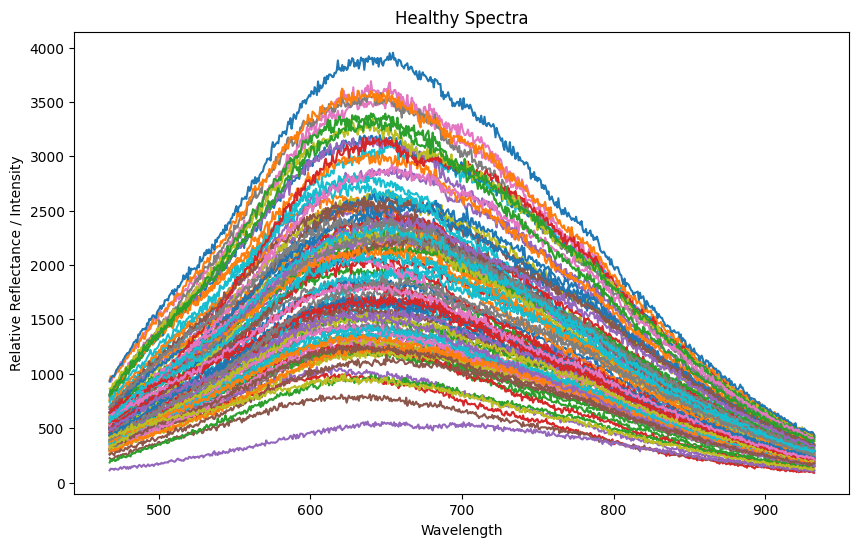

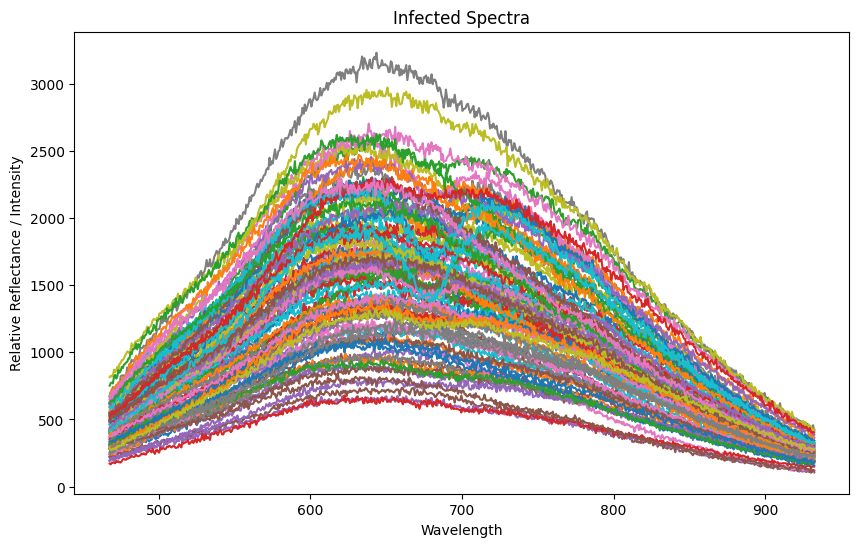

In [280]:
plot_spectra(healthy_sampled_all_seeds, 'Healthy Spectra')
plot_spectra(infected_sampled_all_seeds, 'Infected Spectra')

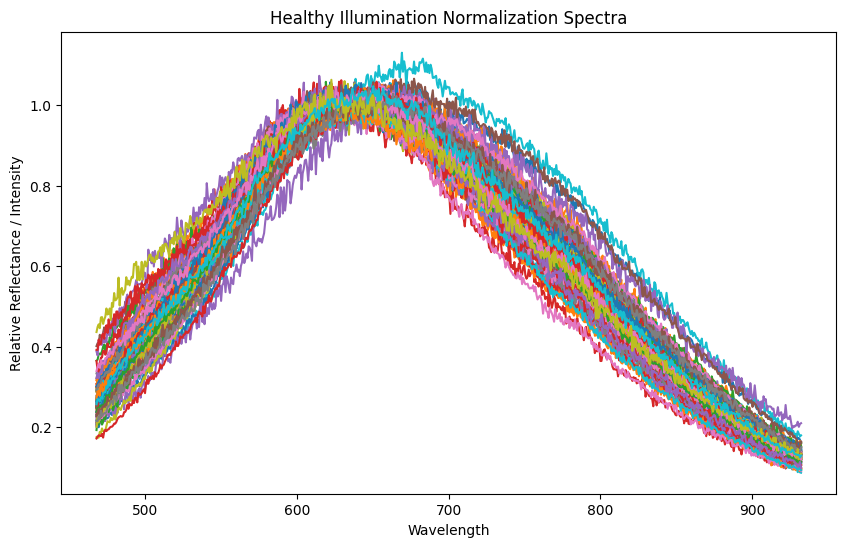

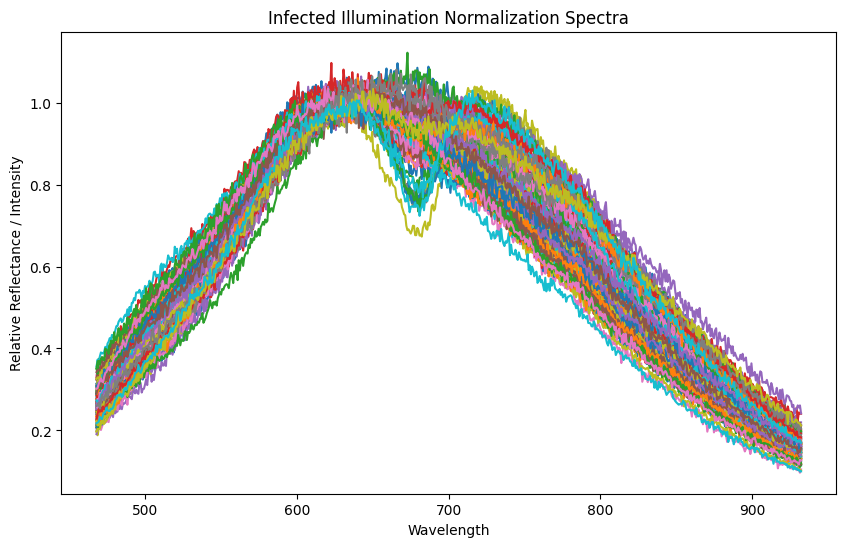

In [281]:
plot_spectra(illumination_ratio_based_normalization(healthy_sampled_all_seeds), 'Healthy Illumination Normalization Spectra')
plot_spectra(illumination_ratio_based_normalization(infected_sampled_all_seeds), 'Infected Illumination Normalization Spectra')

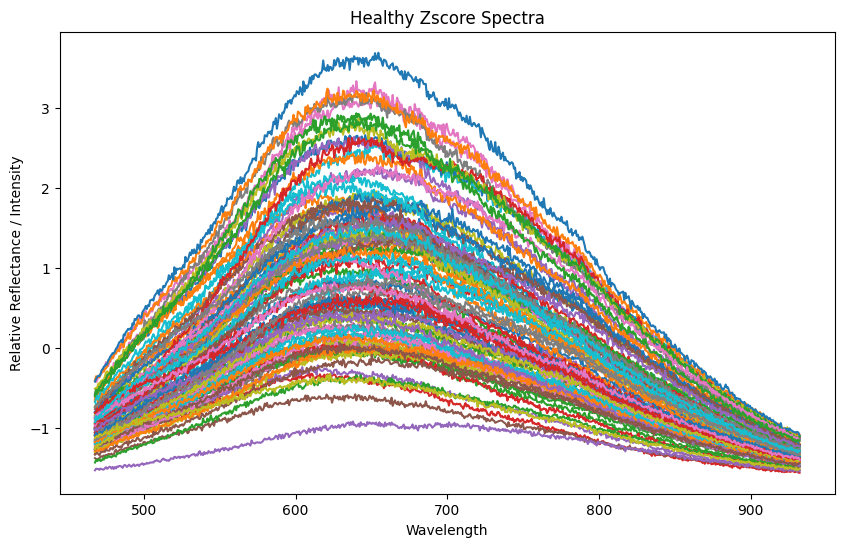

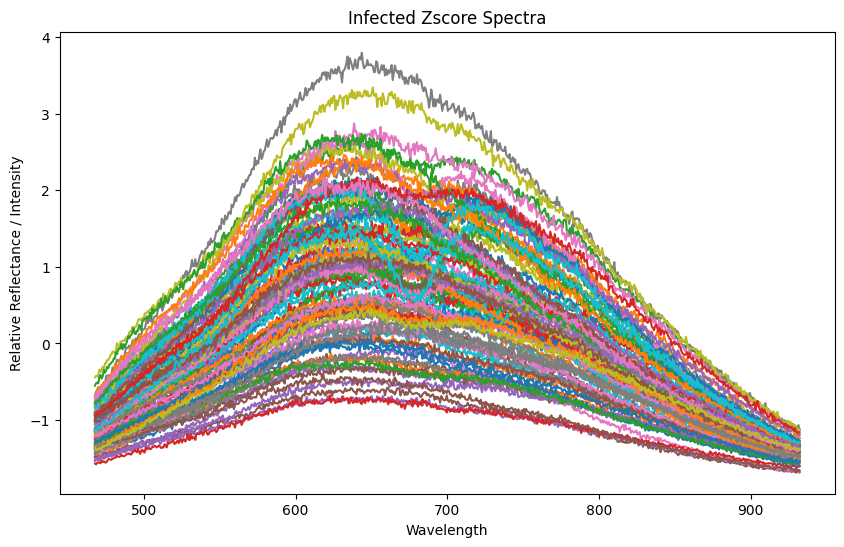

In [282]:
plot_spectra(zscore_normalize(healthy_sampled_all_seeds), 'Healthy Zscore Spectra')
plot_spectra(zscore_normalize(infected_sampled_all_seeds), 'Infected Zscore Spectra')

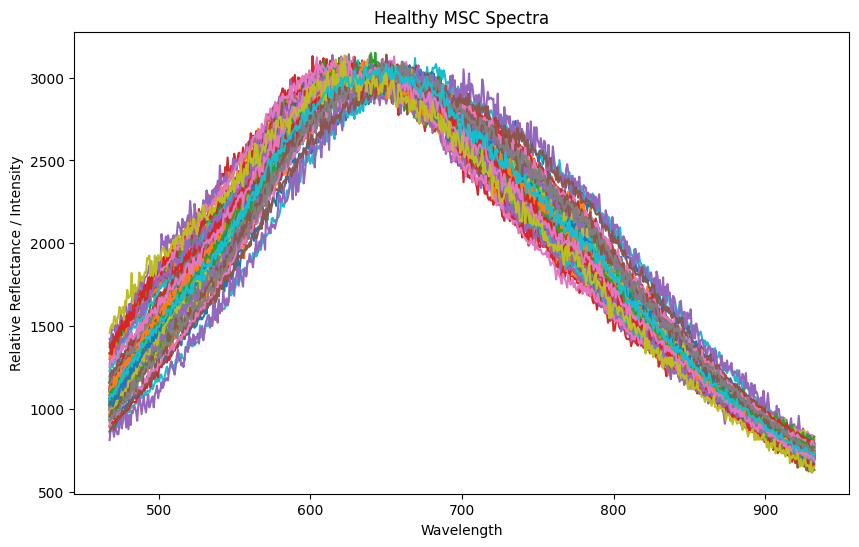

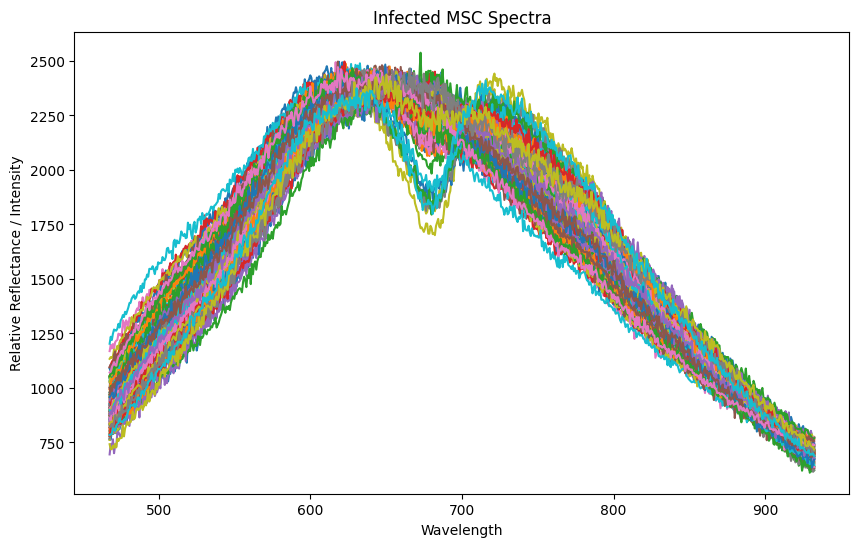

In [283]:
most_consistent_band = find_the_most_consistant_band()
ref_spectrum = healthy_sampled_all_seeds[:, most_consistent_band]  # other bands could be used like ref_spectrum = np.mean(healthy_sampled_all_seeds, axis=1)
healthy_sampled_msc_spectra = apply_msc_and_shift_positive(healthy_sampled_all_seeds, ref_spectrum)
plot_spectra(healthy_sampled_msc_spectra, 'Healthy MSC Spectra')
ref_spectrum = infected_sampled_all_seeds[:, most_consistent_band]
infected_sampled_msc_spectra = apply_msc_and_shift_positive(infected_sampled_all_seeds, ref_spectrum)
plot_spectra(infected_sampled_msc_spectra, 'Infected MSC Spectra')

In [284]:
healthy_illumination_zscore_normalized = zscore_normalize(illumination_ratio_based_normalization(healthy_sampled_all_seeds))
infected_illumination_zscore_normalized = zscore_normalize(illumination_ratio_based_normalization(infected_sampled_all_seeds))

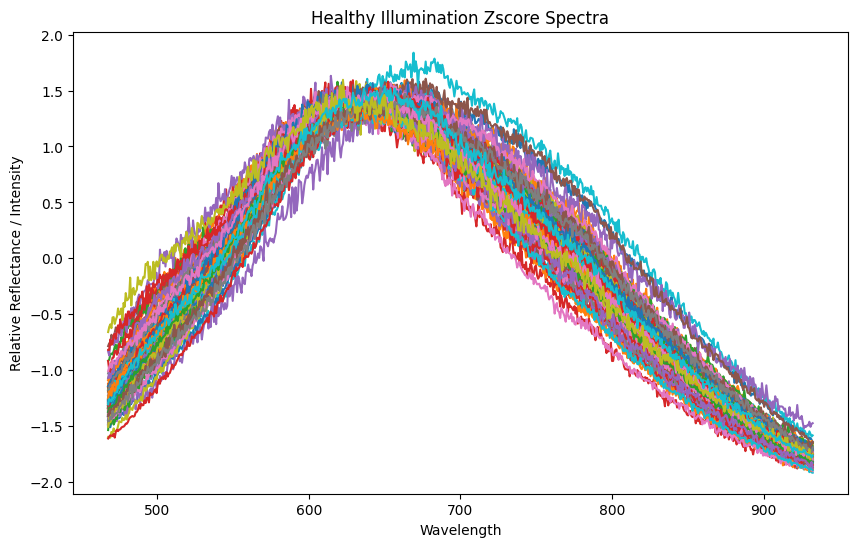

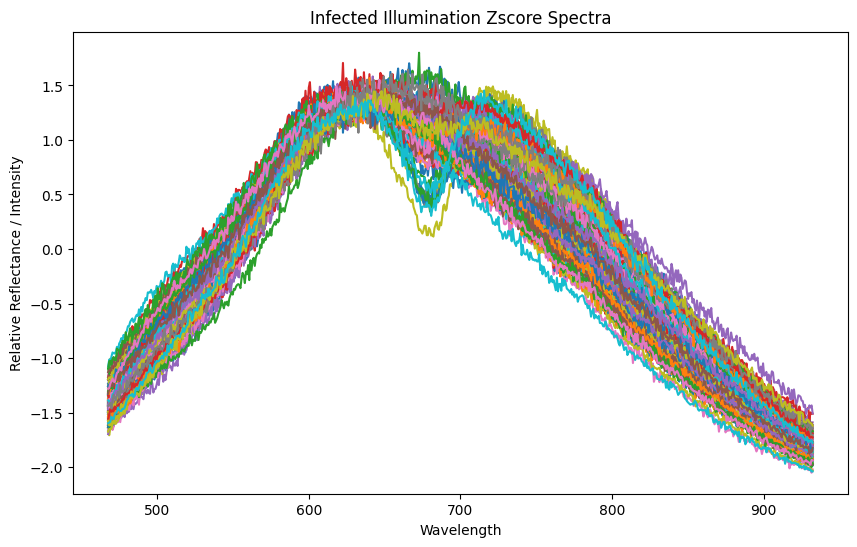

In [285]:
plot_spectra(zscore_normalize(healthy_illumination_zscore_normalized), 'Healthy Illumination Zscore Spectra')
plot_spectra(zscore_normalize(infected_illumination_zscore_normalized), 'Infected Illumination Zscore Spectra')